This notebook's purpose is to visualise the tidal ellipses along the thalweg.

In [8]:
import os
import glob
import datetime
import matplotlib.pylab as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Ellipse
import numpy as np
from IPython.display import display, Math, Latex
import csv
import pandas as pd
import re
import subprocess as sp
from subprocess import Popen, PIPE

import netCDF4 as nc
from scipy.optimize import curve_fit
import scipy.io as sio
from salishsea_tools import (viz_tools,tidetools, nc_tools)
from salishsea_tools.nowcast import (research_VENUS, analyze)

%matplotlib inline

#Load the parameters
The thalweg had 1539 pair of points. I chose 15 stations at increments of 100 points along the thalweg and calculated the tidal ellipse parameters for these locations

In [9]:
grid_B = nc.Dataset('/data/dlatorne/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
lats = grid_B.variables['nav_lat'][:]
lons = grid_B.variables['nav_lon'][:]
bathy = grid_B.variables['Bathymetry'][:,:]

In [23]:
to = datetime.datetime(2014,11,26)
tf = datetime.datetime(2015, 7, 7)

t_o = to.strftime('%d%b%y').lower()
t_f = tf.strftime('%d%b%y').lower()

thalweg = np.loadtxt('/data/dlatorne/MEOPAR/tools/bathymetry/thalweg_working.txt', dtype=int, unpack=True)
loc = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1303, 1400, 1500]
count = np.arange(0,16)
params = np.zeros((16,39,8))
params_av = np.zeros((16,8))
cols=np.arange(0,8)

i = np.zeros((16))
j = np.zeros((16))

for k,l in zip(loc,count):
    i = thalweg[1,loc]
    j = thalweg[0,loc]
    runname1 = '{}_{}_thalweg_{}'.format(t_o, t_f, k)
    runname2 = '{}_{}_thalweg_{}_depav(0-400)'.format(t_o, t_f, k)
    df1 = pd.read_csv('/ocean/mdunn/MEOPAR/analysis/Muriel/TidalEllipseData/Thalweg/'+runname1+'.csv', usecols=cols) 
    df2 = pd.read_csv('/ocean/mdunn/MEOPAR/analysis/Muriel/TidalEllipseData/Thalweg/'+runname2+'.csv', index_col=False)
    params[l,:,:] = df1.as_matrix()
    params_av[l,:] = df2.as_matrix()


##Plot of locations

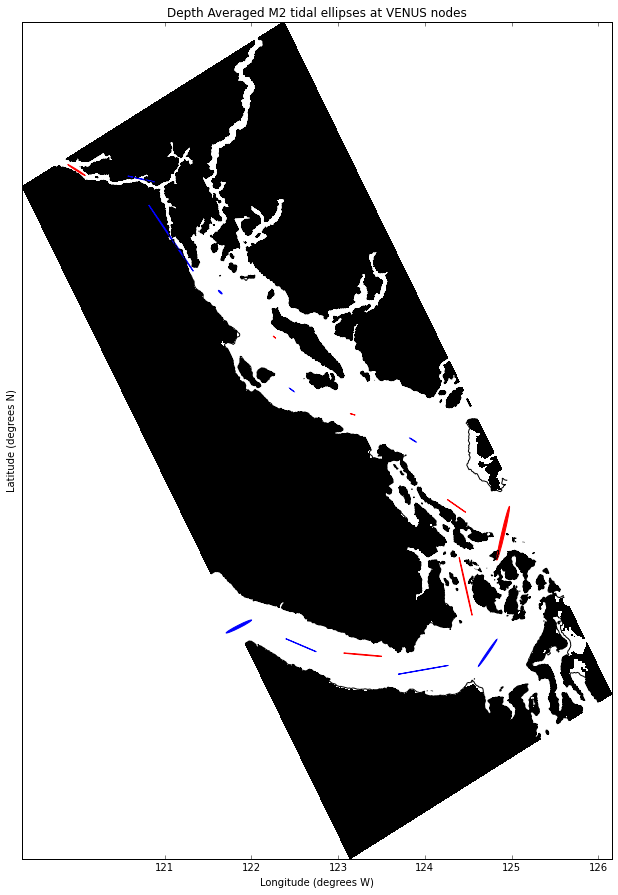

In [12]:
phi=29
fig = plt.figure(figsize=(15,15))
k = np.zeros((898,398)); m = np.zeros((898,398))
ax = fig.add_subplot(111)
viz_tools.set_aspect(ax) 
ex = 0

imin=0
imax = 330

jmin = 150
jmax = 895

for q in np.arange(jmin-ex,jmax+ex):
    for l in np.arange(imin-ex,imax+ex):
        k[q,l] = q*np.cos(phi*np.pi/180.)+l*np.sin(phi*np.pi/180.)
        m[q,l] = -q*np.sin(phi*np.pi/180.)+l*np.cos(phi*np.pi/180.) 
scale = 75

#Making the ellipse for the Central node

count = np.arange(0,16)

for loc, r, l in zip(count, i ,j):
    if params_av[loc,1] > 0:
        thec = 'b'
    else:
        thec = 'r'
    ellsc = Ellipse(xy=(m[l,r],k[l,r]), width=scale*params_av[loc,0], 
                        height=scale*params_av[loc,1], angle=params_av[loc,2],
                        color=thec)
    ax.add_artist(ellsc)
    ellsc.set_facecolor(thec)

# y-axis in k, but labelled in latitude
#ax.set_ylim(300,350)
slope = (lats[jmax,imax]-lats[jmin,imin])/(k[jmax,imax]-k[jmin,imin])
mylist = (k[jmax,imax]+(np.arange(44, 50, 0.5)-
                           lats[jmin,imin])/slope).tolist()
labels = ['44.5','45','45.5','46','47','48', '49','50']
ax.set_yticks(mylist)
ax.set_yticklabels(labels)
ax.set_ylabel('Latitude (degrees N)')
# x-axis in m, but labelled in longitude
#ax.set_xlim(100,120)
slope = (lons[jmax,imax]-lons[jmin,imin])/(m[jmax,imax]-m[jmin,imin])
mylist = (m[jmax,imax]+(np.arange(-127,-120.5,1)-
                        lons[jmin,imin])/slope).tolist()
labels = ['127','126','125','124','123','122','121', '120']
ax.set_xticks(mylist)
ax.set_xticklabels(labels)
ax.set_xlabel('Longitude (degrees W)')

# land, and 5 m contour
contour_interval = [-0.01, 0.01]
ax.contourf(m[jmin-ex:jmax+ex,imin-ex:imax+ex],k[jmin-ex:jmax+ex,imin-ex:imax+ex],
        bathy.data[jmin-ex:jmax+ex,imin-ex:imax+ex],contour_interval,colors='black')
ax.contour(m[jmin-ex:jmax+ex,imin-ex:imax+ex],k[jmin-ex:jmax+ex,imin-ex:imax+ex],
            bathy.data[jmin-ex:jmax+ex,imin-ex:imax+ex],[5],colors='black')
ax.set_title('Depth Averaged M2 tidal ellipses at VENUS nodes')


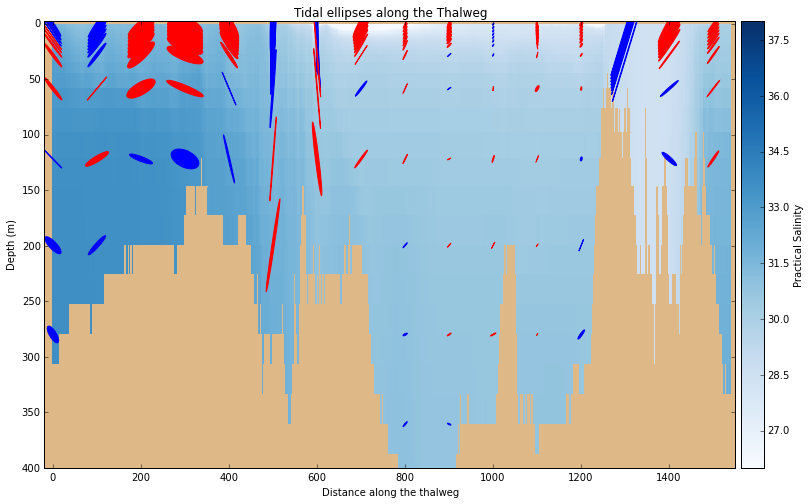

In [13]:
# Set up the figure and axes
fig, (axl, axcb) = plt.subplots(1, 2, figsize=(16, 8))
land_colour = 'burlywood'
axl.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))

smin, smax, dels = 26, 38, 0.5
cmap = plt.get_cmap('Blues')
cmap.set_bad(land_colour)
tracers = nc.Dataset('/ocean/dlatorne/MEOPAR/SalishSea/results/spin-up/18sep27sep/SalishSea_1d_20030918_20030927_grid_T.nc')
sal = tracers.variables['vosaline']
npsal = sal[:]
zlevels = tracers.variables['deptht']
sal_0 = npsal[-1, :, thalweg[0], thalweg[1]]
sal_tzyx = np.ma.masked_values(sal_0, 0)
x, z = np.meshgrid(np.arange(thalweg.shape[1]), zlevels)
mesh = axl.pcolormesh(x, z, sal_tzyx.T, cmap=cmap, vmin=smin, vmax=smax)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Practical Salinity')

scale = 100
count = np.arange(0,16)
k = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1303, 1400, 1500]

for loc, k in zip(count, k):
    for dep, value in zip(np.arange(0,39,3), params[0,:,0][::3]):
        if params[loc,dep,2] > 0:
            thec = 'b'
        else:
            thec = 'r'
        ellsc = Ellipse(xy=(k, value), width=scale*params[loc,dep,1], 
                            height=scale*params[loc,dep,2], angle=params[loc, dep,3],
                            color=thec)
        axl.add_artist(ellsc)
        ellsc.set_facecolor(thec)


axl.set_ylim(-2,400)
axl.invert_yaxis()
axl.set_xlim(-20,1550)
axl.set_title('Tidal ellipses along the Thalweg')
axl.set_ylabel('Depth (m)')
axl.set_xlabel('Distance along the thalweg')

The ellipses vary alot along the thalweg of the Salish Sea.
They start out quite large and relatively circular in the Juan de Fuca Strait. Through Haro Strait they ellipses are pointing very close to north and have a narrow, estuarian like shape (rectilinear). The ellipses are very small and have no significant structure in the deep areas of the Georgia Strait. The currents are extremely fast and consistent through Seymour Narrows compared to the middle of the Strait then they seems similar to after Haro Strait or near the end of the Juan de Fuca Strait but smaller.

## Find lat and lon of Thalweg locations
To calculate the foreman model ellipses I need to input the latitude and longitude of my locations of interest.

In [14]:
lat_thal = lats[j[:],i[:]]
lon_thal = lons[j[:],i[:]]

In [16]:
params_ft = np.zeros((16,8))
os.chdir(r'/ocean/mdunn/Tides/')
for k in count:
    p = Popen(["matlab","-nodesktop","-nodisplay","-r", "findparam(%s,%s)" % (lon_thal[k], lat_thal[k])], stdout=PIPE, stderr=PIPE)
    output, err = p.communicate()
    params_ft[k] = np.loadtxt('output.txt')

In [19]:
print "             Salish Sea Model         |     Foreman Model    "
print "  Major-Axis   Minor-Axis    Angle    | Major-Axis    Minor-Axis      Angle"
print "    (m/s)         (m/s)   (deg ccw E) |   (m/s)         (m/s)      (deg ccw E)"   
for r in np.arange(0,16):
    print '     {0:4.2f}        {1:5.2f}        {2:3.0f}     |    {3:4.2f}         {4:5.2f}         {5:3.0f}   '.format( 
         params_av[r,0], params_av[r,1], params_av[r,2], params_ft[r,0], params_ft[r,1], params_ft[r,2]) 


             Salish Sea Model         |     Foreman Model    
  Major-Axis   Minor-Axis    Angle    | Major-Axis    Minor-Axis      Angle
    (m/s)         (m/s)   (deg ccw E) |   (m/s)         (m/s)      (deg ccw E)
     0.41         0.04         24     |    0.52         -0.01           9   
     0.48         0.00        159     |    0.65         -0.01         155   
     0.56        -0.01        176     |    0.70         -0.00         170   
     0.74         0.00          9     |    0.83          0.02           6   
     0.44         0.02         52     |    0.44          0.04          40   
     0.77        -0.01        104     |    0.83          0.02         110   
     0.71        -0.04         75     |    0.55         -0.02          82   
     0.32        -0.01        148     |    0.38         -0.00         146   
     0.11         0.01        151     |    0.11          0.00         145   
     0.08        -0.00        165     |    0.06          0.00         155   
     0.08    


##Visual Comparison! 
The adventures of the tidal ellipse along the thalweg

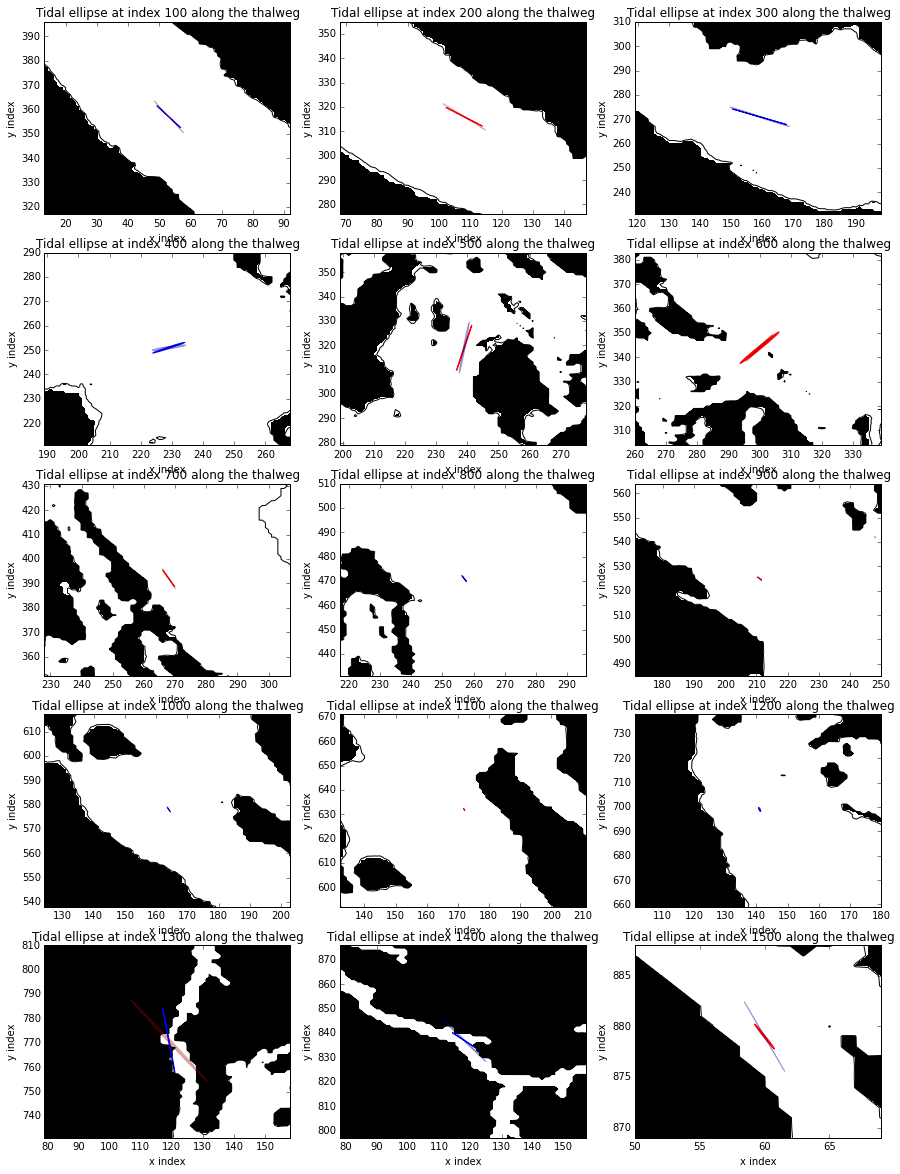

In [20]:

phi=0
fig, ax = plt.subplots(5 , 3, figsize=(15,20))
k = np.zeros((898,398))
m = np.zeros((898,398))
ex = 40

count = np.arange(1,16)
xes = [0,1,2,0,1,2,0,1,2,0,1,2,0,1,2]
xis = [0,0,0,1,1,1,2,2,2,3,3,3,4,4,4]
for a, b ,c, axis, axes in zip(i[1:], j[1:], count,xis, xes): 
    
    imin = a
    imax = a

    jmin = b
    jmax = b
    scale = 25
    if c ==15:
        ex=10
        scale = 10
    for q in np.arange(jmin-ex,jmax+ex):
        for l in np.arange(imin-ex,imax+ex):
            k[q,l] = q*np.cos(phi*np.pi/180.)+l*np.sin(phi*np.pi/180.)
            m[q,l] = -q*np.sin(phi*np.pi/180.)+l*np.cos(phi*np.pi/180.)
    
    #Making the ellipse Salish Sea Model
    if params_av[c,1] > 0:
         thec = 'b' 
    else:
        thec = 'r'
    ellsc1 = Ellipse(xy=(m[b,a],k[b,a]), width=scale*params_av[c,0], 
                            height=scale*params_av[c,1], angle=params_av[c,2]-29,
                            color=thec)
    ax[axis,axes].add_artist(ellsc1)
    ellsc1.set_facecolor(thec)

    #Making the ellipse Foreman model
    if params_ft[c,1] > 0:
        thec = [0,0,0.6, 0.3]
    else:
        thec = [0.6,0,0, 0.3]
    ellsc = Ellipse(xy=(m[b,a],k[b,a]), width=scale*params_ft[c,0], 
                            height=scale*params_ft[c,1], angle=params_ft[c,2]-29,
                            color=thec)
    ax[axis,axes].add_artist(ellsc)
    ellsc.set_facecolor(thec)
    # land, and 5 m contour
    contour_interval = [-0.01, 0.01]
    ax[axis,axes].contourf(m[jmin-ex:jmax+ex,imin-ex:imax+ex],k[jmin-ex:jmax+ex,imin-ex:imax+ex],
            bathy.data[jmin-ex:jmax+ex,imin-ex:imax+ex],contour_interval,colors='black')
    ax[axis,axes].contour(m[jmin-ex:jmax+ex,imin-ex:imax+ex],k[jmin-ex:jmax+ex,imin-ex:imax+ex],
                bathy.data[jmin-ex:jmax+ex,imin-ex:imax+ex],[5],colors='black')
    ax[axis,axes].set_title('Tidal ellipse at index {} along the thalweg'.format(c*100))
    ax[axis,axes].set_xlabel('x index')
    ax[axis,axes].set_ylabel('y index')
    


##Line Graph
This graph helps visalise the changes of each parameters along the thalweg and facilitates the comparisons between difference information sources.

In [1]:
#Add approximate current meter location information
JW = 5
JE = 285
HS = 492
SN = 1298
locCM = [JW, JE, HS, SN]
labels = ['Juan de Fuca W', 'Juan de Fuca E', 'Haro Strait','Seymour Narrows']
csv1 = pd.read_csv('/ocean/mdunn/MEOPAR/analysis/Muriel/param_mat.csv', index_col=False)
param_mat = csv1.as_matrix()
csv2 = pd.read_csv('/ocean/mdunn/MEOPAR/analysis/Muriel/params.csv', index_col=False)
params = csv2.as_matrix()
obspha = [[294, 304, 321, 113],[196, 21, 221, 337]]
obsamp = [0.389, 0.735, 0.513, 4.661]

NameError: name 'pd' is not defined

In [107]:
loc = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1303, 1400, 1500]
count = np.arange(0,16)
parameter = ['major-axis', 'minor-axis', 'inclination']
unit = ['m/s','m/s','deg']

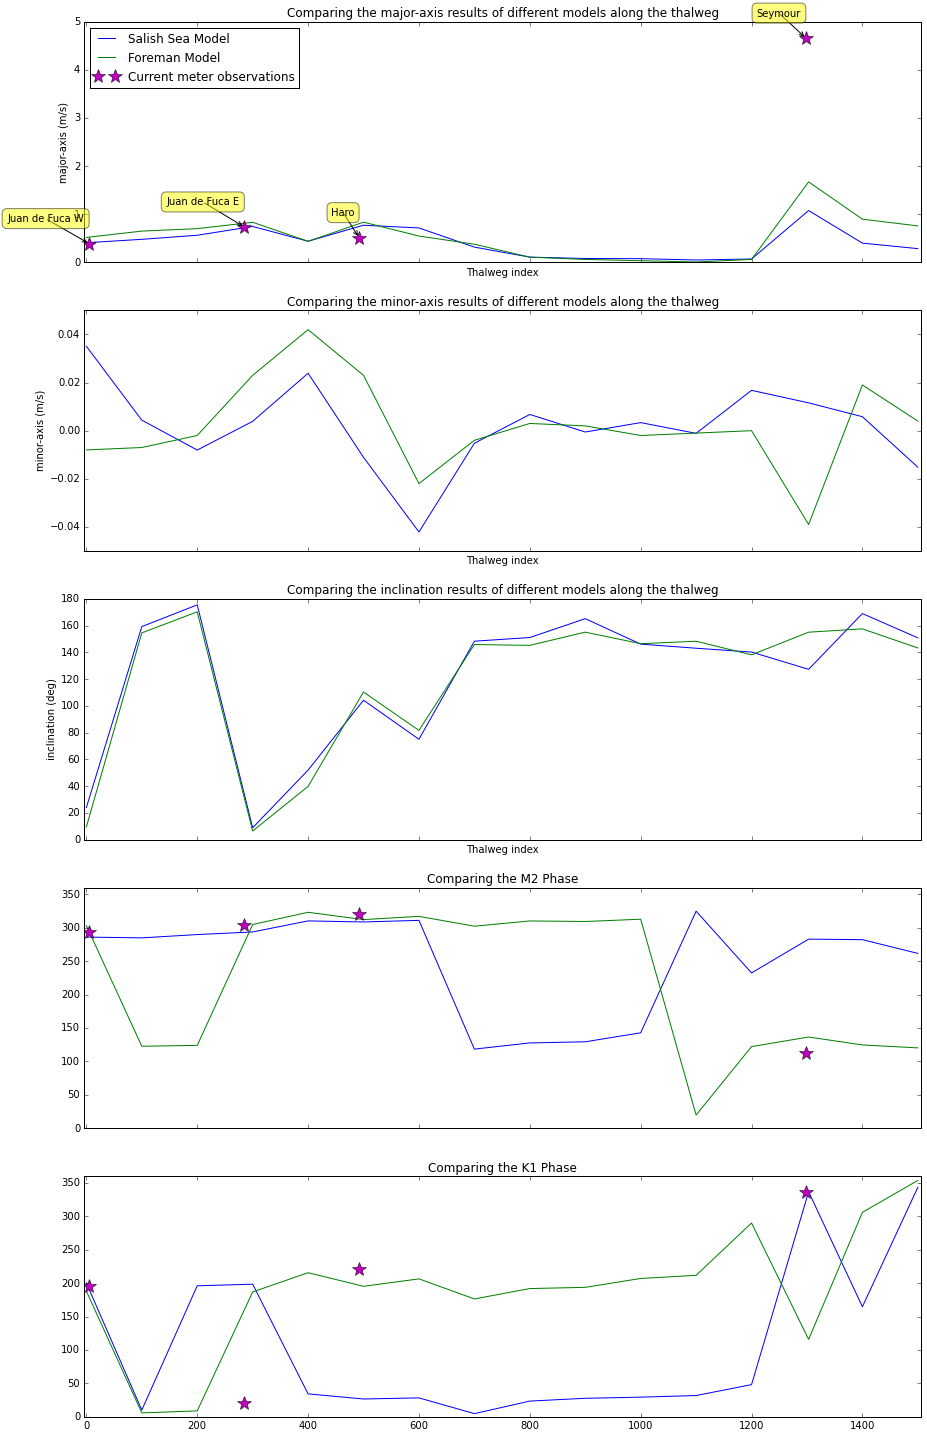

In [114]:
fig, (ax0, ax1, ax2, ax3, ax4)= plt.subplots(5,1,figsize=(15,25), sharex=True)

for ax , k, par, u in zip([ax0, ax1, ax2], np.arange(0,3), parameter, unit):
    ax.plot(loc[:],params_av[:,k], '-', label='Salish Sea Model')
    ax.plot(loc[:], params_ft[:,k], '-', label='Foreman Model')
    ax.set_title('Comparing the {} results of different models along the thalweg'.format(par))
    ax.set_xlabel('Thalweg index')
    ax.set_ylabel('{} ({})'.format(par,u))
    ax.set_xlim([-5, 1505])

for ax, ind, k in zip([ax3,ax4], [0,1], [3,7]):
    ax.plot(loc[:],params_av[:,k], '-', label='Salish Sea Model')
    ax.plot(loc[:], params_ft[:,k], '-', label='Foreman Model')
    ax.plot(locCM[:], obspha[ind][:], 'm*', markersize = 14, label='Current meter observations')
    ax.set_ylim([0,360])
    
for label, x, y in zip(labels, locCM, obsamp):
    ax0.annotate(
        label, 
        xy = (x, y), xytext = (-5, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
ax0.plot(locCM[:], obsamp[:], 'm*', markersize = 14, label='Current meter observations')
ax3.set_title('Comparing the M2 Phase')
ax4.set_title('Comparing the K1 Phase')
ax0.legend(loc=0)